In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

/home/op/miniconda3/envs/p39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dataset generation

In [16]:
def generate_task_subsets(num_tasks, num_bits, task_sizes, random_state = 0):
  np.random.seed(random_state)
  task_subsets = np.zeros((num_tasks, num_bits))
  for i in range(num_tasks):
    task_subsets[i][np.random.choice(num_bits, size = task_sizes[i], replace = False)] = 1
  return task_subsets

def create_dataset(num_tasks, num_bits, task_freq, task_subsets, num_samples, num_batches = 1, random_state = 0):
  np.random.seed(random_state)
  # generate task-subsets
  # task_subsets = np.zeros((num_tasks, num_bits))
  # for i in range(num_tasks):
  #   task_subsets[i][np.random.choice(num_bits, size = task_sizes[i], replace = False)] = 1
  # print("task subsets")
  # print(task_subsets)
  all_tasks = np.arange(num_tasks)

  for i in range(num_batches):
    # sample tasks
    tasks = np.random.choice(all_tasks, size = num_samples, p = task_freq / task_freq.sum())

    # generate control bits with respect to task frequencies
    control_bits = np.eye(num_tasks)[tasks]
    # print("control bit shapes")
    # print(control_bits)
    # print(control_bits.shape)

    # generate task strings
    task_bits = np.random.randint(2, size = (num_samples, num_bits))
    # print("task bit shapes")
    # print(task_bits)
    # print(task_bits.shape)

    # generate output strings
    task_masks = task_subsets[tasks]
    # print("task mask shapes")
    # print(task_masks)
    # print(task_masks.shape)
    
    out = np.sum(task_bits * task_masks, axis = 1) % 2
    input = np.concatenate([control_bits, task_bits], axis = 1)
    # print(input.shape)

    return input, out

In [17]:
[x for x in create_dataset(2, 4, np.array([1, 1]), generate_task_subsets(2, 4, np.array([1, 4])), num_samples = 3, num_batches = 2)]

[array([[0., 1., 1., 1., 1., 1.],
        [0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.]]),
 array([0., 0., 0.])]

# Train one model

In [18]:
batches = 10000
num_tasks = 8
n = 100
alpha = 0.4

mlp = nn.Sequential(
    nn.Linear(num_tasks + n, 500),
    nn.ReLU(),
    nn.Linear(500, 2)
)

optimizer = torch.optim.Adam(mlp.parameters(), lr = 1e-3)
loss_func = nn.CrossEntropyLoss(reduction = "mean")

# power law scaling with uniform task hardness
power_law = (np.arange(num_tasks) + 1) ** (-alpha - 1)
power_law = power_law / power_law.sum()
task_subsets = generate_task_subsets(num_tasks, n, np.ones(num_tasks, int) * 3)
train_data = create_dataset(num_tasks, 100, power_law, task_subsets, 20000, batches)

# uniform frequency, varied task hardness
# frequencies = np.ones(num_tasks)
# frequencies = frequencies / frequencies.sum()
# subset_sizes = np.arange(100)
# task_subsets = generate_task_subsets(num_tasks, n, subset_sizes)
# train_data = create_dataset(num_tasks, n, frequencies, task_subsets, 20000, batches)

# test_data = [x for x in create_dataset(500, 100, power_law, task_subsets, 2000, 1, 1)][0]

In [19]:
mps_device = torch.device("cuda")
mps_device

device(type='cuda')

In [20]:
def eval_subtasks(model, task_subsets, loss_func, samples_per_task = 50):
  n_tasks = task_subsets.shape[0]
  n = task_subsets.shape[1]

  task_bits = np.random.randint(2, size = (samples_per_task * n_tasks, n))
  output_bits = np.zeros(samples_per_task * n_tasks, dtype = int)
  # create outputs for every subtask
  for i in range(n_tasks):
    input_slice = task_bits[i * samples_per_task : (i + 1) * samples_per_task]
    outputs = np.sum(input_slice * task_subsets[i], axis = 1) % 2
    output_bits[i * samples_per_task:(i + 1) * samples_per_task] = outputs
  input_bits = np.eye(n_tasks)[np.repeat(np.arange(n_tasks), samples_per_task)]
  # print(input_bits.shape)

  total_input = np.concatenate([input_bits, task_bits], axis = 1)
  # calculate the loss for each (in bits)
  mod_outputs = model(torch.from_numpy(total_input).float().to(mps_device))
  loss = loss_func(mod_outputs, torch.from_numpy(output_bits).long().to(mps_device))
  # print(loss.shape)
  # return loss in bits for every subtask
  loss = loss.cpu()

  losses = loss.reshape(-1, samples_per_task).mean(axis = 1) / np.log(2)
  # print(losses.shape)
  return losses


In [21]:
def train_loop(mlp, train_data, mps_device, loss_func, optimizer, task_subsets, eval_subtasks): 
    losses = []
    big_losses = []
    for i, (x, y) in enumerate(zip(train_data)):
        if i % 1000 == 0:
            print(f"batch {i}")
        mlp.train()
        mlp.to(mps_device)
        optimizer.zero_grad()

        x, y = torch.from_numpy(x).float().to(mps_device), torch.from_numpy(y).long().to(mps_device)
        outputs = mlp(x)
        loss = loss_func(outputs, y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        if i % 5 == 0:
            mlp.eval()
            with torch.no_grad():
                big_losses.append(eval_subtasks(mlp, task_subsets, nn.CrossEntropyLoss(reduction = 'none'), 100))
            
    return losses, big_losses

In [22]:
all_losses = []
all_big_losses = []

for hidden_dim in tqdm([1,2,3,4,5,10,25,50,100,250,500]):

  mlp = nn.Sequential(
    nn.Linear(num_tasks + n, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 2)
  )

  optimizer = torch.optim.Adam(mlp.parameters(), lr = 1e-3)
  loss_func = nn.CrossEntropyLoss(reduction = "mean")

  curr_model_losses, curr_model_big_losses = train_loop(mlp, train_data, mps_device, loss_func, optimizer, task_subsets, eval_subtasks)

  all_losses.append(curr_model_losses)
  all_big_losses.append(curr_model_big_losses)


  0%|          | 0/11 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [9]:
all_losses

[[0.788327157497406,
  0.7923715114593506,
  0.7894395589828491,
  0.7900050282478333,
  0.7825450897216797,
  0.7877992391586304,
  0.7835628390312195,
  0.7902779579162598,
  0.7893377542495728,
  0.7840961217880249,
  0.785912036895752,
  0.79034423828125,
  0.7896902561187744,
  0.7844529747962952,
  0.7937912344932556,
  0.7853278517723083,
  0.7866945862770081,
  0.7892987728118896,
  0.7874473333358765,
  0.7891362309455872,
  0.7923785448074341,
  0.7923007607460022,
  0.7909206748008728,
  0.7833049297332764,
  0.782678484916687,
  0.7861862778663635,
  0.7885116934776306,
  0.7919010519981384,
  0.7908321022987366,
  0.7922051548957825,
  0.7876726388931274,
  0.7861616015434265,
  0.7885028123855591,
  0.7886006236076355,
  0.7895770072937012,
  0.7866565585136414,
  0.7888740301132202,
  0.7867639660835266,
  0.7868425846099854,
  0.786376953125,
  0.7941932082176208,
  0.7847257852554321,
  0.7927870154380798,
  0.7854304909706116,
  0.7882553935050964,
  0.784368276596069

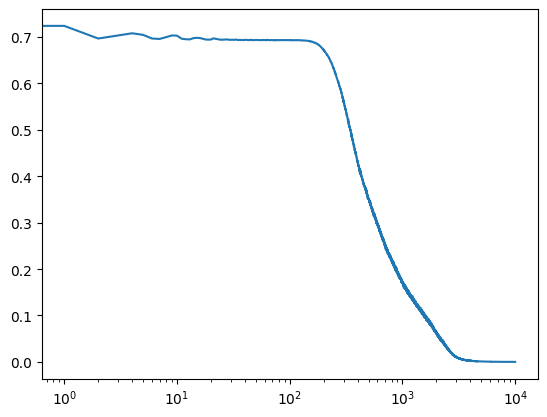

In [15]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)), losses)
plt.xscale("log")

In [16]:
big_losses = np.array([bl.numpy() for bl in big_losses])

In [17]:
big_losses.shape

(2000, 8)

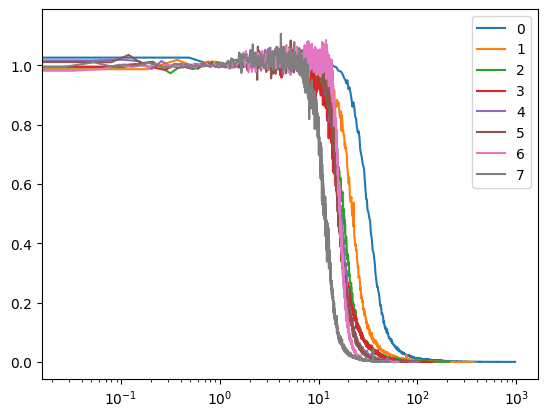

In [19]:
for i in range(8):
  plt.plot(np.arange(big_losses.shape[0]) * power_law[i], big_losses[:, i], label = i)
plt.legend()
plt.xscale("log")

In [20]:
mlp.eval()

Sequential(
  (0): Linear(in_features=108, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=2, bias=True)
)

In [21]:
mlp[0].weight.shape # (500, 600)
# x: (600, 1); X: (m, 600) -> Wx or XW^t
# want to see: representation of x = (0)_500 (0..1..0)_100
# Wx -> column of W
# want PCA of last 100 columns of W

torch.Size([500, 108])

In [22]:
col_last = mlp[0].weight[:, -100:].cpu().detach().numpy()
col_last.shape

(500, 100)

In [23]:
from sklearn.decomposition import PCA

In [24]:
pca = PCA(n_components=3)
pca.fit(col_last.T)

PCA(n_components=3)

In [25]:
pca_col_last = pca.transform(col_last.T)
control_bits = mlp[0].weight[:, :-100].cpu().detach().numpy() # (500, 500)
pca_control = pca.transform(control_bits.T)

In [26]:
pca_col_last.shape

(100, 3)

In [27]:
pca.explained_variance_ratio_

array([0.08307768, 0.07172736, 0.06842233], dtype=float32)

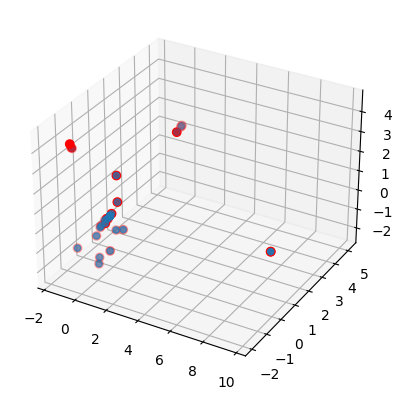

In [29]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter(pca_col_last[:, 0], pca_col_last[:, 1], pca_col_last[:, 2])
for i in range(8):
    inds = np.where(task_subsets[i] != 0)
    ax.scatter(pca_col_last[inds[0], 0], pca_col_last[inds[0], 1], pca_col_last[inds[0], 2], color = "red", s = 36)

(array([ 2, 26, 86]),)